In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings(action='once')

## Problem 1

In [2]:
def test(sample_size, sample_num):
    samples = sample_num
    skews, kurts = np.empty(samples), np.empty(samples)
    np.random.seed(88)
    for i in range(samples):
        r = np.random.normal(size=sample_size)
        skews[i] = skew(r)
        kurts[i] = kurtosis(r)
    pvalue_skew = stats.ttest_1samp(skews, 0.0)[1]
    pvalue_kurt = stats.ttest_1samp(kurts, 0.0)[1]
    print("skewness: " + "sample_size: {}, ".format(sample_size) + "p-value: {}".format(pvalue_skew))
    print("excess kurtosis: " + "sample_size: {}, ".format(sample_size) + "p-value: {}".format(pvalue_kurt))

In [3]:
sample_size = [10, 1000, 5000, 10000]
print('sample number: 1000')
for i in sample_size:
    test(i, 1000)
print('')
print('sample number: 10000')
for i in sample_size:
    test(i, 10000)

sample number: 1000
skewness: sample_size: 10, p-value: 0.8013330507292313
excess kurtosis: sample_size: 10, p-value: 1.037057346073577e-93
skewness: sample_size: 1000, p-value: 0.20626851421156314
excess kurtosis: sample_size: 1000, p-value: 0.004751463963982129
skewness: sample_size: 5000, p-value: 0.4944354419025637
excess kurtosis: sample_size: 5000, p-value: 0.05713524742555986
skewness: sample_size: 10000, p-value: 0.7186501568415584
excess kurtosis: sample_size: 10000, p-value: 0.47127723529495313

sample number: 10000
skewness: sample_size: 10, p-value: 0.42289396455440864
excess kurtosis: sample_size: 10, p-value: 0.0
skewness: sample_size: 1000, p-value: 0.7053550978791081
excess kurtosis: sample_size: 1000, p-value: 2.9532513426038536e-05
skewness: sample_size: 5000, p-value: 0.14438508259647287
excess kurtosis: sample_size: 5000, p-value: 0.13105735887511824
skewness: sample_size: 10000, p-value: 0.19632155033792742
excess kurtosis: sample_size: 10000, p-value: 0.6284556433

<pre>
small sample sizes
    - skewness: fail to reject "unbiased"
    - kurtosis: reject "unbiased"
    
large sample sizes
    - skewness: fail to reject "unbiased"
    - kurtosis: fail to reject "unbiased"

In [4]:
def first4Moments(sample):
    n = len(sample)
    μ_hat = np.mean(sample)
    sim_corrected = sample - μ_hat
    cm2 = sim_corrected.T.dot(sim_corrected)/n
    σ2_hat = sim_corrected.T.dot(sim_corrected)/(n-1)
    skew_hat = sum(sim_corrected**3)/n/np.sqrt(cm2*cm2*cm2)
    kurt_hat = sum(sim_corrected**4)/n/cm2**2
    excessKurt_hat = kurt_hat - 3
    return μ_hat, σ2_hat, skew_hat, excessKurt_hat

# a ton of samples and compare each stats.skew(sample) to a biased estimate
samples = 1000000
skews = np.empty(samples)
np.random.seed(88)
for i in range(samples):
    r = np.random.normal(size=10)
    skews[i] = skew(r) - first4Moments(r)[2]
mx, mn = np.max(skews), np.min(skews)
print("max diff: ",mx)
print("min diff: ",mn)

max diff:  1.9984014443252818e-15
min diff:  -1.9984014443252818e-15


## Problem 2

### Q1

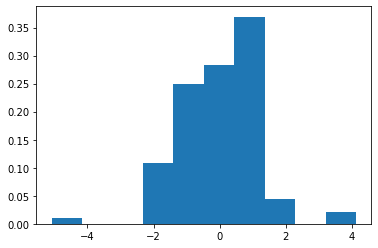

Mean of error vector: -1.6653345369377347e-17
Variance of error vector: 1.436148485406261
Skewness of error vector: -0.271353974448504
Excess kurtosis of error vector: 3.4211883977033253
ols fit params:
const    0.119836
x        0.605205
dtype: float64


In [5]:
data = pd.read_csv("problem2.csv")
x = data['x']
y = data['y']
X = sm.add_constant(x)
model = sm.OLS(y, X)
result_ols = model.fit()
error_vector = result_ols.resid
coef_ols = result_ols.params

mean = np.mean(error_vector)
variance = np.var(error_vector)
skew = stats.skew(error_vector, bias=False)
kurtosis = stats.kurtosis(error_vector, bias=False)

plt.hist(error_vector, density=True)
plt.show()

print("Mean of error vector:", mean)
print("Variance of error vector:", variance)
print("Skewness of error vector:", skew)
print("Excess kurtosis of error vector:", kurtosis)
print("ols fit params:")
print(coef_ols)

### Q2

In [6]:
def normal_ll(params):
    beta = params[:-1]
    s = params[-1]
    n = len(y)
    xm = y - np.dot(X, beta)
    s2 = s*s
    ll = -n/2 * np.log(s2 * 2 * np.pi) - np.dot(xm.T, xm)/(2*s2)
    return -ll

def t_ll(params):
    beta = params[:-2]
    s = params[-2]
    nu = params[-1]
    xm = y - np.dot(X, beta)
    ll = stats.t.logpdf(xm, nu, scale=s, loc=0).sum() # x's, shape(df), scale, mean
    return -ll

def AIC(ll):
    return 6 - 2*ll

def BIC(ll):
    return 3*np.log(len(y)) - 2*ll

In [7]:
n_res = minimize(normal_ll, [0, 0, 1])
normal_fit = n_res.x[0] + n_res.x[1]*x
normalLL = -n_res.fun
n_AIC = AIC(normalLL)
n_BIC = BIC(normalLL)
print(n_res)
print("Normal params:", n_res.x[0], n_res.x[1])
print("t R-sq:", r2_score(y,normal_fit))
print("Normal AIC:", n_AIC)
print("Normal BIC:", n_BIC)

print('')

t_res = minimize(t_ll, [0, 0, 1, 5.0])
t_fit = t_res.x[0] + t_res.x[1]*x
tLL = -t_res.fun
t_AIC = AIC(tLL)
t_BIC = BIC(tLL)
print(t_res)
print("t params:", t_res.x[0], t_res.x[1])
print("t R-sq:", r2_score(y,t_fit))
print("t AIC:", t_AIC)
print("t BIC:", t_BIC)

      fun: 159.99209668916234
 hess_inv: array([[ 1.45241655e-02, -1.85746534e-04, -5.35572833e-05],
       [-1.85746534e-04,  1.60865140e-02, -3.93707576e-04],
       [-5.35572833e-05, -3.93707576e-04,  7.46484109e-03]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([0.11983619, 0.60520482, 1.19839412])
Normal params: 0.11983619399961781 0.6052048162026642
t R-sq: 0.19463952391895067
Normal AIC: 325.9841933783247
Normal BIC: 333.79970393628895

      fun: 155.4729704124877
 hess_inv: array([[ 1.22668117e-02,  8.99178673e-04, -1.00772202e-03,
        -3.17778482e-02],
       [ 8.99178673e-04,  1.35321911e-02,  2.26035766e-04,
         1.55180666e-02],
       [-1.00772202e-03,  2.26035766e-04,  9.31501554e-03,
         1.35159183e-01],
       [-3.17778482e-02,  1.55180666e-02,  1.35159183e-01,
         7.56866634e+00]])
      jac: array([-1.90734863e-06, -1.9073486

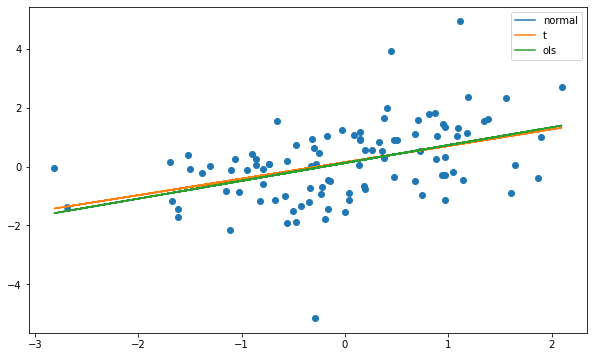

In [8]:
ols_fit = coef_ols.const + coef_ols.x * x
plt.figure(figsize=(10,6))
plt.scatter(x,y)
plt.plot(x, normal_fit, label='normal')
plt.plot(x, t_fit, label='t')
plt.plot(x, ols_fit, label='ols')
plt.legend()
plt.show()

'normal' and 'ols' overlap.

## Problem 3

In [9]:
def ar_process(arparams, order, ma=0):
    ar = np.array([arparams]*order)
    ma = np.array([ma])
    ar = np.r_[1, ar]
    ma = np.r_[1, ma]
    y = arma_generate_sample(ar, ma, nsample=1000)
    return y

In [10]:
def ma_process(maparams, order, ar=0):
    ar = np.array([ar])
    ma = np.array([maparams]*order)
    ar = np.r_[1, ar]
    ma = np.r_[1, ma]
    y = arma_generate_sample(ar, ma, nsample=1000)
    return y

/Users/xinyiwan/miniforge3/envs/cyber/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


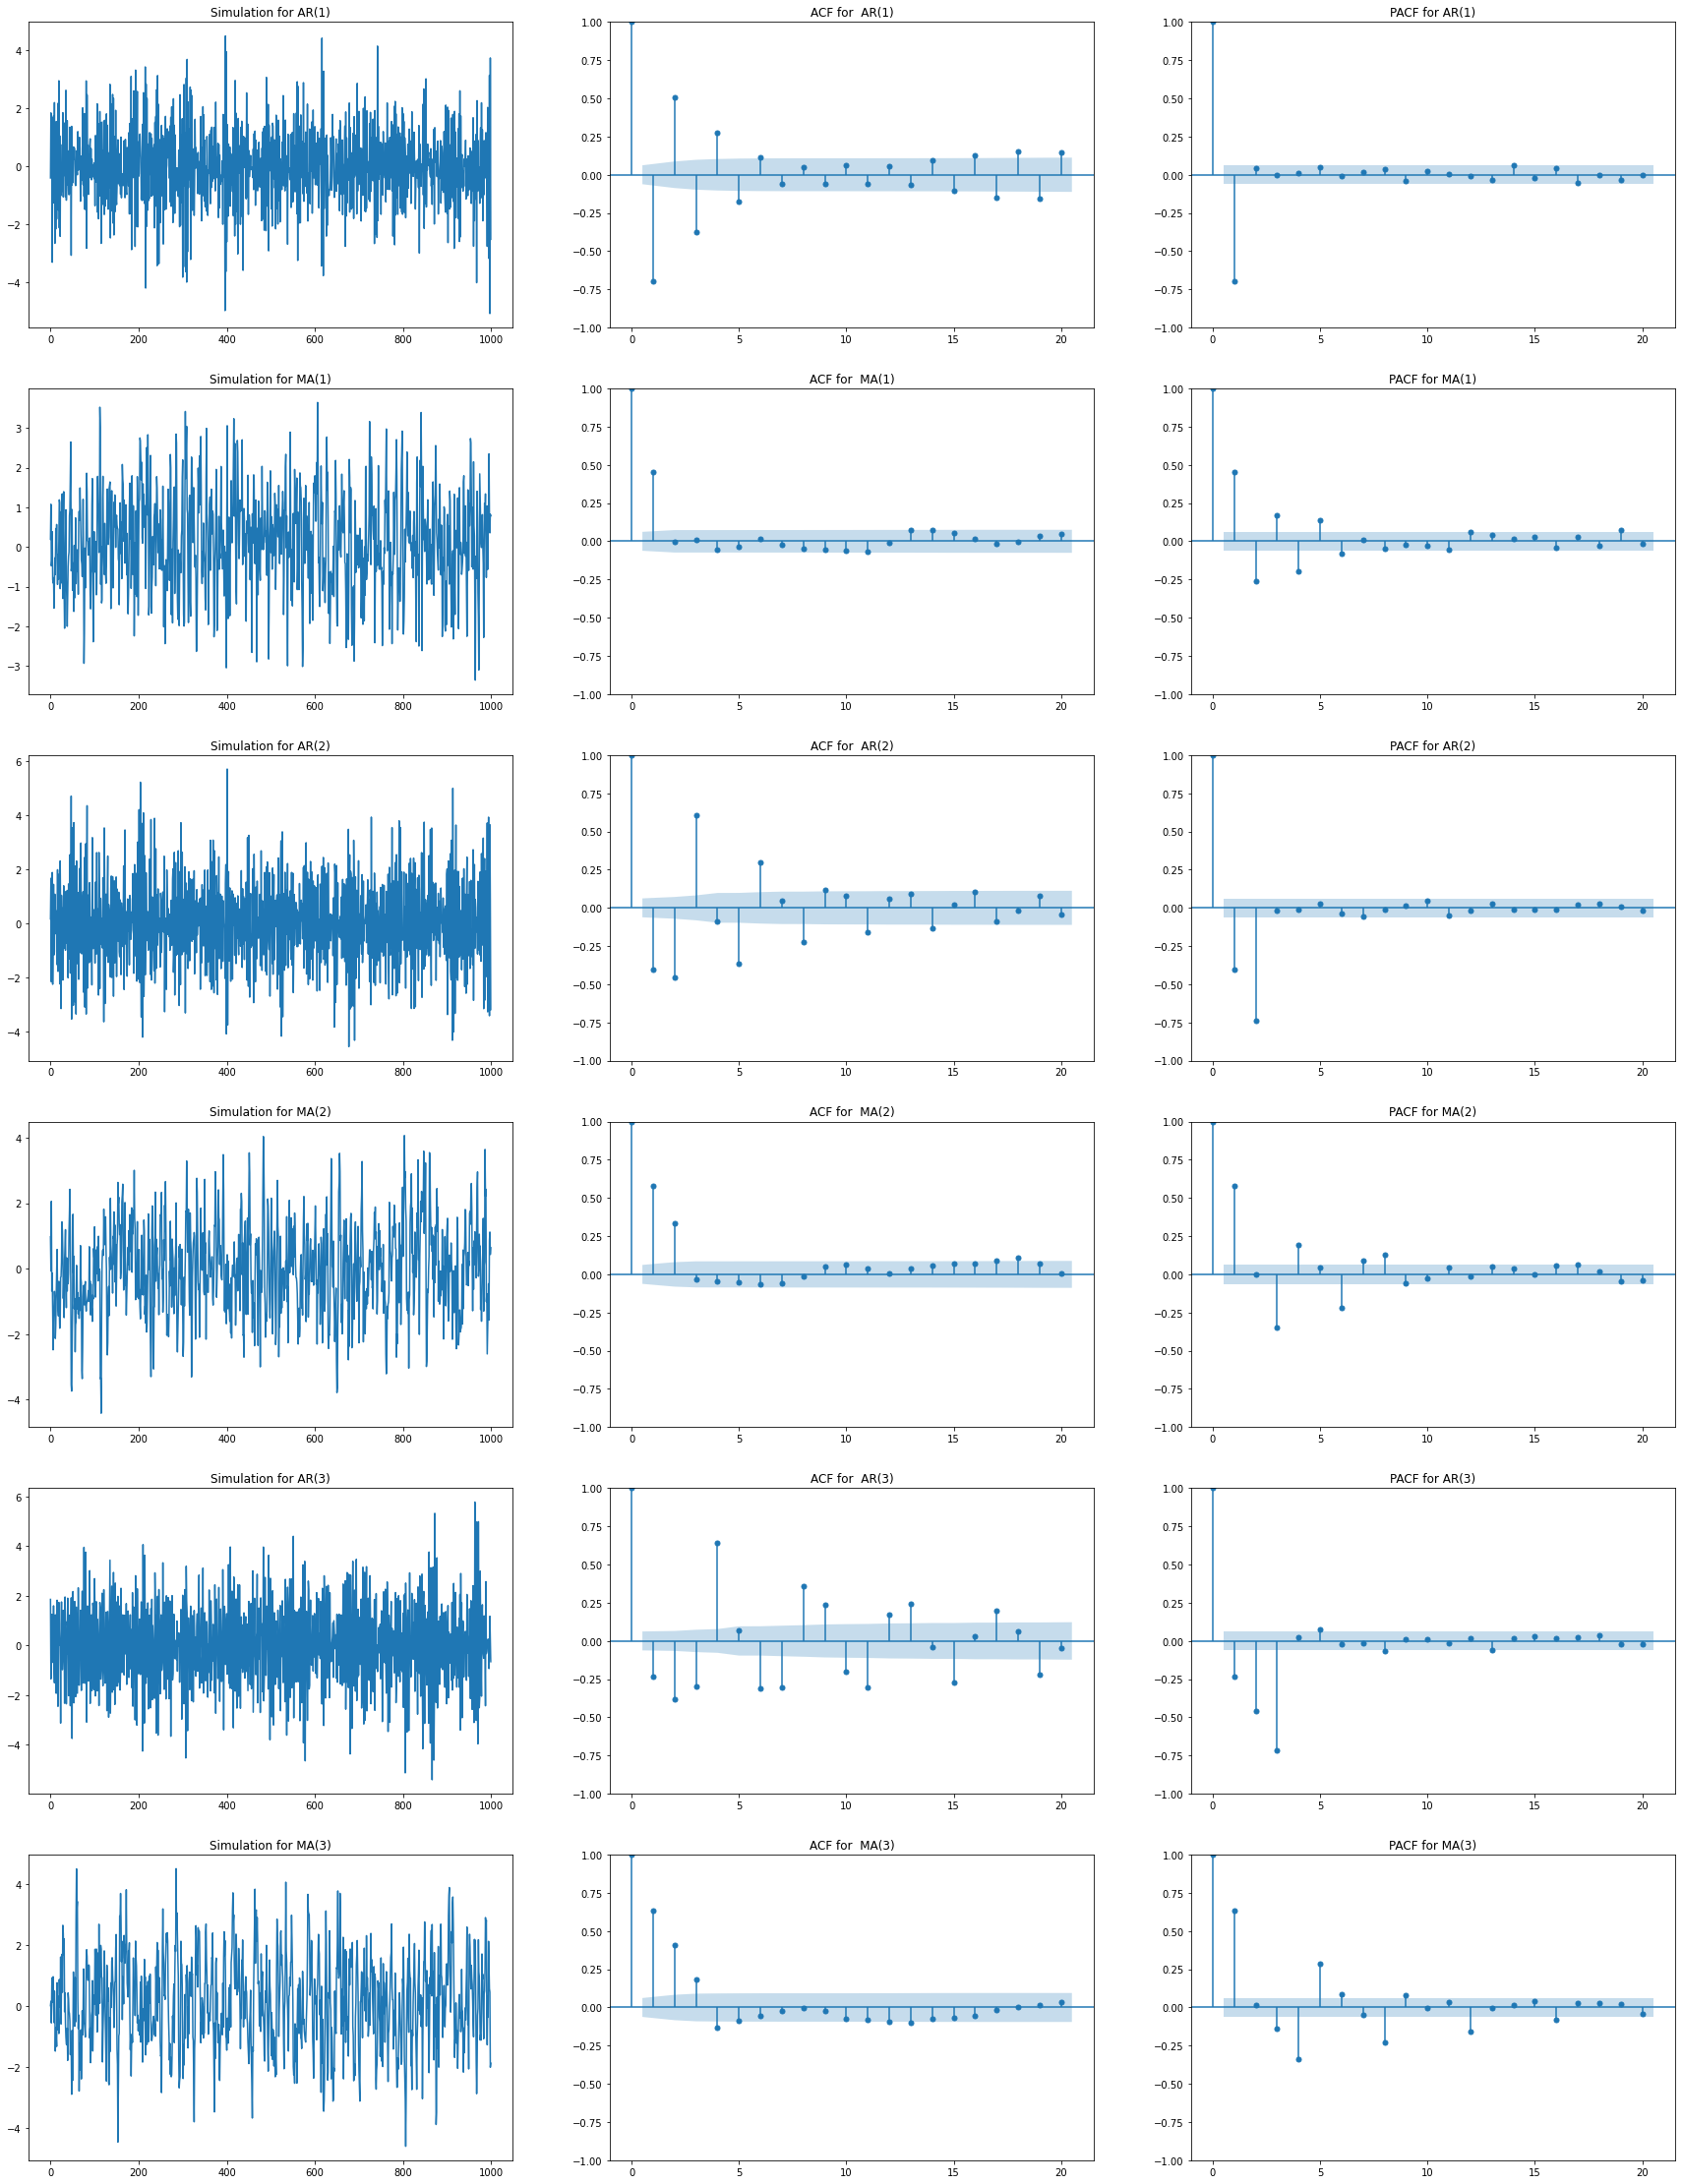

In [11]:
list_y = []
list_type_order = ['AR(1)','MA(1)','AR(2)','MA(2)','AR(3)','MA(3)']
for i in range(1,4):
    y1 = ar_process(0.7,i).tolist()
    y2 = ma_process(0.7,i).tolist()
    list_y.append(y1)
    list_y.append(y2)
fig, axs = plt.subplots(6,3,figsize=(30,40))
for i,y in enumerate(list_y):
    axs[i,0].plot(y)
    plot_acf(y, lags=20, ax=axs[i,1])
    plot_pacf(y, lags=20, ax=axs[i,2])
    axs[i,0].set_title('Simulation for ' + list_type_order[i])
    axs[i,1].set_title('ACF for  ' + list_type_order[i])
    axs[i,2].set_title('PACF for ' + list_type_order[i])
# plt.savefig('ARMA_processes.png', dpi=300, facecolor='white')
plt.show()